# Process
In this notebook, I will check whether other properties relate with popularity in the data for authors.

# A. Import Libraries

In [1]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import matplotlib.pyplot as plt
import random as rd
import pandas as pd
import numpy as np
from split_users import split
from collections import Counter
from scipy import stats
from analyze_data import item_distribution

# B. Set hyperparameters
There are certain hyperparameters that need to be tuned before the run. 

In [2]:
item_threshold = 5 # remove users with less than item_threshold items
user_threshold = 5 # remove items with less than user_threshold users
top_threshold = 200 # remove users who have rated more than top_threshold items
recommendation_type = "books" # books, music or movies
item_col = "ISBN" # the item column
user_col = "User-ID"
my_seed = 0 # random_seed
top_fraction_users = 0.2# the limit for a user to be considered High Preference
top_fraction_items = 0.2
split_popularity_by = "pop_fraq"
split_gender_by = "male_female_difference" 
split_country_by = "ratio_USA"

These additions will be useful so we can save the different files (plots and processed data) with clarity on the hyperparameters.

In [3]:
addition_1 = "_u"+str(item_threshold)+"_i"+str(user_threshold)+"_t"+str(top_threshold)
addition_2 = addition_1 + "_tfi"+str(int(100*top_fraction_items))
addition_3 = addition_2 + "_tfu"+str(int(100*top_fraction_users))
addition_4 = addition_3 + ("_sbpf" if (split_popularity_by=="pop_fraq") else "_sbpif")
addition_gender = addition_1 + "_tfu"+str(int(100*top_fraction_users))+  "_mfd"
addition_country = addition_1 + "_tfu"+str(int(100*top_fraction_users))+ "_USAr"

In [4]:
rd.seed(my_seed) #seed for random functions
np.random.seed(my_seed) #seed for all numpy fuctions

# C. Read files

In [5]:
processed_file_location = "data/processed/" # here we store the processed data files

In [6]:
properties_file_location = "data/files_with_properties/" # here are stored the data files that include author properties

ratings_file = properties_file_location + "fairbook_ratings_with_readable_properties_filtered_correct_ISBNs.csv" # the ratings file
ratings_with_properties = pd.read_csv(ratings_file, index_col=0, header=0, low_memory=False).fillna("")

In [7]:
ratings_with_properties = ratings_with_properties[["User-ID", "Book-Rating","QID","country", "gender"]]

In [8]:
ratings_with_properties.head()

,User-ID,Book-Rating,QID,country,gender
1,276847,10,Q34660,United Kingdom,female
2,276847,10,Q34660,United Kingdom,female
3,276847,10,Q34660,United Kingdom,female
4,276847,10,Q34660,United Kingdom,female
5,276964,10,Q172140,United States of America,male


## Popularity of authors

In [9]:
num_users = len(ratings_with_properties["User-ID"].unique())

In [10]:
ratings_with_properties_test = ratings_with_properties[ratings_with_properties.QID != ""]

In [11]:
item_dist = ratings_with_properties_test["QID"].value_counts()
num_items = len(item_dist)

In [12]:
df_item_dist = pd.DataFrame(item_dist) # turn the series into a dataframe
df_item_dist.columns = ['count']
#df_item_dist['count'] /= num_users

In [13]:
df_item_dist

,count
Q39829,2528
Q106465,1958
Q231356,1848
Q311671,1413
Q272076,1181
...,...
Q260900,5
Q314897,5
Q7344794,5
Q464371,5


## Define dicts

In [14]:
gender_dict = {}
country_dict = {}
for author in ratings_with_properties_test["QID"].unique():
    gender_dict[author] = ratings_with_properties_test.gender[ratings_with_properties_test["QID"] == author].iloc[0]
    country_dict[author] = ratings_with_properties_test.country[ratings_with_properties_test["QID"] == author].iloc[0]

In [15]:
df_item_dist["gender"] = ""
df_item_dist["country"] = ""

for index, row in df_item_dist.iterrows():
    gender = gender_dict[index]
    country = country_dict[index]
    df_item_dist.at[index, "gender"] = gender
    df_item_dist.at[index, "country"] = country

## Final

In [16]:
df_item_dist.iloc[:10]

,count,gender,country
Q39829,2528,male,United States of America
Q106465,1958,male,United States of America
Q231356,1848,female,United States of America
Q311671,1413,male,United States of America
Q272076,1181,male,United States of America
Q184785,1029,female,United States of America
Q231467,996,female,United States of America
Q34660,970,female,United Kingdom
Q240547,969,female,United States of America
Q172140,947,male,United States of America


In [17]:
num_pop_items = int(top_fraction_items * len(df_item_dist))
pop_item_dist = df_item_dist.iloc[:num_pop_items]

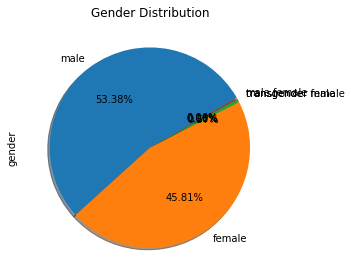

In [18]:
fig, ax = plt.subplots()
df_item_dist.gender.value_counts().plot(kind="pie",autopct='%.2f%%', shadow=True
                                      , startangle=30)
ax.tick_params(labelrotation=0)
ax.title.set_text("Gender Distribution")
fig.tight_layout()

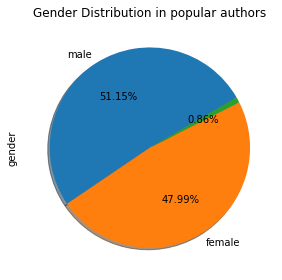

In [19]:
fig, ax = plt.subplots()
pop_item_dist.gender.value_counts().plot(kind="pie",autopct='%.2f%%', shadow=True
                                      , startangle=30)
ax.tick_params(labelrotation=0)
ax.title.set_text("Gender Distribution in popular authors")
fig.tight_layout()

/var/folders/kh/k3tdtq_s5197cmczt3hthfc40000gn/T/ipykernel_9318/1821409258.py:6: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.
  fig.tight_layout()


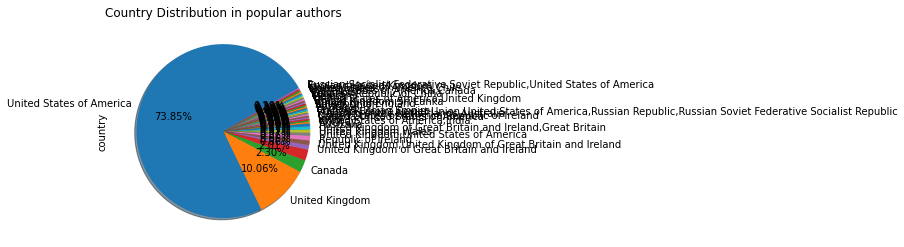

In [20]:
fig, ax = plt.subplots()
pop_item_dist.country.value_counts().plot(kind="pie",autopct='%.2f%%', shadow=True
                                      , startangle=30)
ax.tick_params(labelrotation=0)
ax.title.set_text("Country Distribution in popular authors")
fig.tight_layout()

## Tests

In [21]:
female_popularity = df_item_dist["count"][df_item_dist.gender == "female"].values
male_popularity = df_item_dist["count"][df_item_dist.gender == "male"].values

In [22]:
female_popularity.mean(), male_popularity.mean()

(49.871088861076345, 46.11493018259936)

In [23]:
stats.ttest_ind(female_popularity, male_popularity, trim = 0.2, alternative="greater")

Ttest_indResult(statistic=1.9707033108303578, pvalue=0.02451160796057814)

In [24]:
nonmale_popularity = df_item_dist["count"][df_item_dist.gender != "male"].values
male_popularity = df_item_dist["count"][df_item_dist.gender == "male"].values

In [25]:
nonmale_popularity.mean(), male_popularity.mean()

(49.549815498154985, 46.11493018259936)

In [26]:
stats.ttest_ind(nonmale_popularity, male_popularity)

Ttest_indResult(statistic=0.5364525014921618, pvalue=0.5917143522419857)

In [27]:
USA_popularity = df_item_dist["count"][df_item_dist.country == "United States of America"].values
nonUSA_popularity = df_item_dist["count"][df_item_dist.country != "United States of America"].values

In [28]:
USA_popularity.mean(), nonUSA_popularity.mean()

(54.097725358045494, 34.11669658886894)

In [29]:
stats.ttest_ind(USA_popularity, nonUSA_popularity)

Ttest_indResult(statistic=2.923456355591377, pvalue=0.003506369850896627)

# X

In [30]:
df_item_dist["count"] = df_item_dist["count"] * num_users

In [31]:
df_item_dist

,count,gender,country
Q39829,16062912,male,United States of America
Q106465,12441132,male,United States of America
Q231356,11742192,female,United States of America
Q311671,8978202,male,United States of America
Q272076,7504074,male,United States of America
...,...,...,...
Q260900,31770,female,United States of America
Q314897,31770,male,United Kingdom
Q7344794,31770,male,United States of America
Q464371,31770,female,France
